# CNN for time series analysis

In [1]:
%pip install tensorflow==2.15

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from functions_laura.Data_processing import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.models import load_model


loading of the data and creating the needed data from the dataframe

In [5]:
from functions_laura.Data_processing import resample_with_seasonality
from functions_laura.Data_processing import resample
from functions_laura.Data_processing import add_seasonal
from functions_laura.Data_processing import one_station_resample_with_seasonality
from functions_laura.Data_processing import train_test_split
from functions_laura.Data_cleaning import data_cleaning_datetime

In [6]:
df = pd.read_parquet('../data/hamburg_raw.parquet')

In [7]:
df = data_cleaning_datetime(df)

/Users/laurabrylka/Documents/Git/FuelProphet/functions_laura/Data_cleaning.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = df['date'].apply(lambda x: datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))


do the train-test split

In [6]:
#train_df, test_df = train_test_split(df)

In [8]:
# First, filter for one station
df_one_station = df[df['station_uuid'] == '30a50253-2339-469d-a77c-86713d9f5f7f']

# Define date ranges
train_start = pd.to_datetime("2025-05-01")
train_end = pd.to_datetime("2025-05-18")
test_end = pd.to_datetime("2025-05-26")

# Split into train and test using df_one_station
train_df = df_one_station[
    (df_one_station['datetime'] >= train_start) & 
    (df_one_station['datetime'] < train_end)
]

test_df = df_one_station[
    (df_one_station['datetime'] >= train_end) & 
    (df_one_station['datetime'] <= test_end)
]

# Verify data is present
print("Train df shape:", train_df.shape)
print("Test df shape:", test_df.shape)

Train df shape: (711, 19)
Test df shape: (327, 19)


get data of one station

In [8]:
# we use only the last three weeks as training data
#train_df = test_df[test_df['datetime'] < pd.to_datetime("2025-05-23 00:00")]

In [9]:
# only compute the seasonality on the training data!
test_df = resample(test_df)
train_df = one_station_resample_with_seasonality(train_df, uuid='30a50253-2339-469d-a77c-86713d9f5f7f')

/Users/laurabrylka/Documents/Git/FuelProphet/functions_laura/Data_processing.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['datetime'] = merged_df['date'].apply(lambda x: datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))


In [10]:
# test_df = test_df[
#     (test_df['datetime'] >= pd.to_datetime("2025-05-23")) &
#     (test_df['datetime'] <= pd.to_datetime("2025-05-24"))
# ]

Add the training seasonality to the test set

In [10]:
# Take first 288 values (one complete cycle) and repeat
seasonal_pattern = train_df['seasonal_component'].iloc[:288].values
test_df['seasonal_component'] = np.tile(seasonal_pattern, len(test_df)//288 + 1)[:len(test_df)]

# Verify no NaNs
print(test_df.isna().sum())

datetime              0
e5                    0
seasonal_component    0
dtype: int64


we remove the unnecessary data from test df and add the seasonal component from the training data

In [12]:
#test_df = test_df[test_df['station_uuid'] == '30a50253-2339-469d-a77c-86713d9f5f7f']

In [11]:
test_df_ = pd.DataFrame({
    'datetime': test_df['datetime'],
    'e5' : test_df['e5'],
    'seasonal_component' : test_df['seasonal_component']
})

set datetime as index:

In [12]:
test_df_.set_index('datetime', inplace=True)
train_df.set_index('datetime', inplace=True)

check our data in a plot

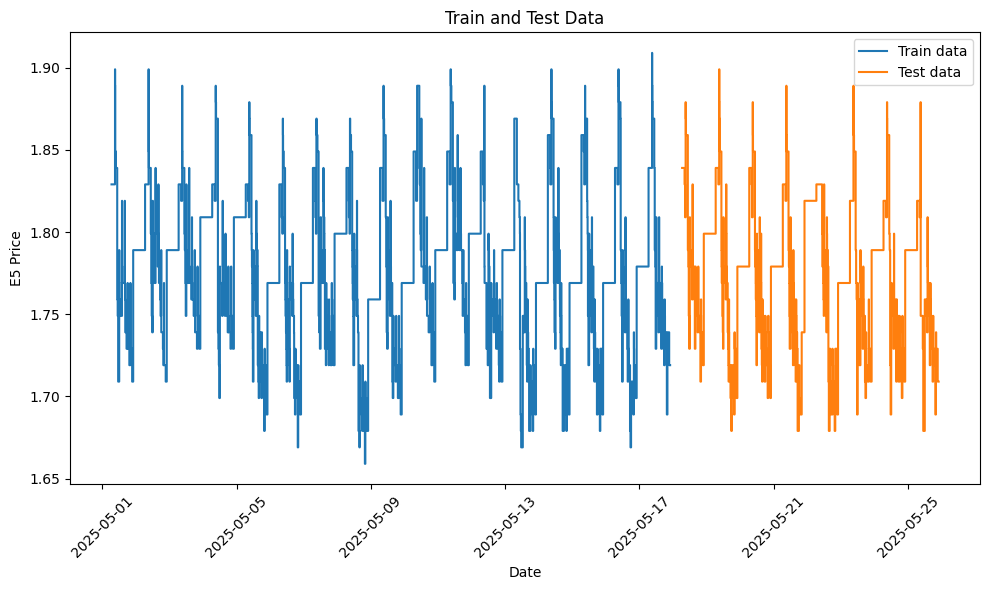

In [13]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['e5'], label='Train data', drawstyle='steps-post')
plt.plot(test_df_.index, test_df_['e5'], label='Test data', drawstyle='steps-post')

plt.xlabel('Date')
plt.ylabel('E5 Price')
plt.title('Train and Test Data')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

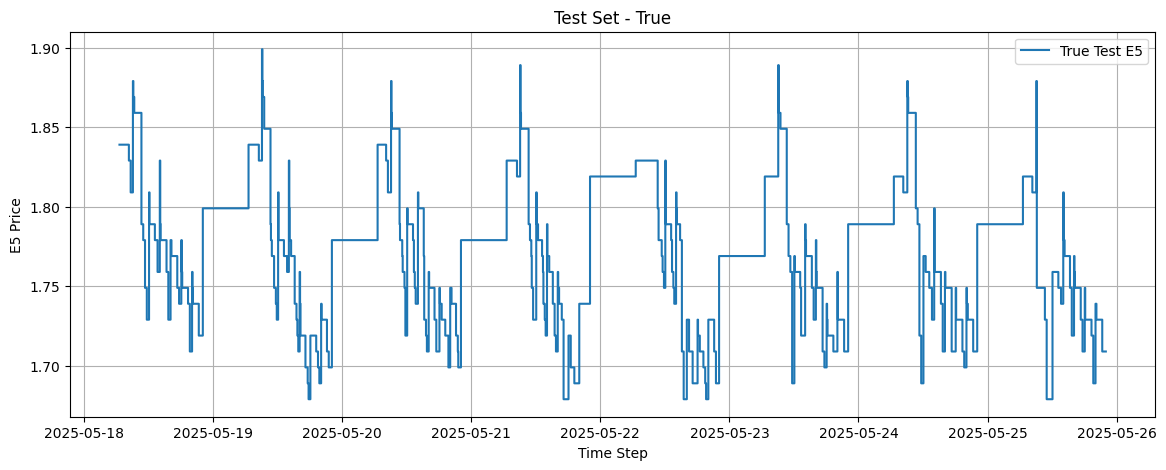

In [14]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'], label='True Test E5', drawstyle='steps-post')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# First, let's verify our actual data range
print("Test set date range:")
print(f"Start: {test_df_.index.min()}")
print(f"End: {test_df_.index.max()}")

Test set date range:
Start: 2025-05-18 06:35:00
End: 2025-05-25 22:00:00


we scale the data

In [16]:
scaler = MinMaxScaler()
scaler.fit(train_df[['e5', 'seasonal_component']])
scaled_train = scaler.transform(train_df[['e5', 'seasonal_component']])
scaled_test = scaler.transform(test_df_[['e5', 'seasonal_component']])

In [17]:
scaled_train[:5]

array([[0.68      , 0.78590961],
       [0.68      , 0.78589762],
       [0.68      , 0.78588563],
       [0.68      , 0.78587363],
       [0.68      , 0.78586164]])

In [18]:
scaled_test[:5]

array([[0.72      , 0.78590961],
       [0.72      , 0.78589762],
       [0.72      , 0.78588563],
       [0.72      , 0.78587363],
       [0.72      , 0.78586164]])

In [19]:
scaled_test.shape

(2202, 2)

### Transforming the data...
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |


In [20]:
def create_sequences(data, window_size, target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)

# Create sequences with e5 as target (index 0)
window_size = 288  # one day of 5-min steps
target_col_index = 0  # e5 price is in first column
X, y = create_sequences(scaled_train, window_size, target_col_index)

# Print shapes to verify
print(f"Input shape: {X.shape}")  # Should be (samples, 288, 2)
print(f"Target shape: {y.shape}") # Should be (samples,)

Input shape: (4506, 288, 2)
Target shape: (4506,)


In [21]:
print(X.shape)

(4506, 288, 2)


In [22]:
X[:5]

array([[[0.68      , 0.78590961],
        [0.68      , 0.78589762],
        [0.68      , 0.78588563],
        ...,
        [0.52      , 0.45779361],
        [0.52      , 0.45778162],
        [0.52      , 0.45776962]],

       [[0.68      , 0.78589762],
        [0.68      , 0.78588563],
        [0.68      , 0.78587363],
        ...,
        [0.52      , 0.45778162],
        [0.52      , 0.45776962],
        [0.68      , 0.78590961]],

       [[0.68      , 0.78588563],
        [0.68      , 0.78587363],
        [0.68      , 0.78586164],
        ...,
        [0.52      , 0.45776962],
        [0.68      , 0.78590961],
        [0.68      , 0.78589762]],

       [[0.68      , 0.78587363],
        [0.68      , 0.78586164],
        [0.68      , 0.78584964],
        ...,
        [0.68      , 0.78590961],
        [0.68      , 0.78589762],
        [0.68      , 0.78588563]],

       [[0.68      , 0.78586164],
        [0.68      , 0.78584964],
        [0.68      , 0.78583765],
        ...,
        [

In [20]:
y.shape

(4506,)

In [21]:
y[:5]

array([0.68, 0.68, 0.68, 0.68, 0.68])

We prepare the Test data -> put in 3 days and predict one day

In [23]:
# Adjust the dates based on actual data
test_end = pd.to_datetime("2025-05-23")  # Update this to match your actual end date
forecast_target_day = test_end
# Use the 3 days before the target day as input
forecast_input_start = forecast_target_day - pd.Timedelta(days=3)
forecast_input_end = forecast_target_day - pd.Timedelta(days=1)

print("\nForecast setup:")
print(f"Using data from {forecast_input_start} to {forecast_input_end}")
print(f"To predict day: {forecast_target_day}")


Forecast setup:
Using data from 2025-05-20 00:00:00 to 2025-05-22 00:00:00
To predict day: 2025-05-23 00:00:00


In [30]:
# Step 1: Calculate window sizes
window_size = 288  # one day
days_input = 3
days_output = 1

total_input_steps = days_input * window_size
total_target_steps = days_output * window_size

# Step 2: Get the slice of scaled_test for exactly what you need
# These are the last (3 days + 1 day) = 1152 samples
reduced_scaled_test = scaled_test[-(total_input_steps + total_target_steps):-total_target_steps]

# Step 3: Create one input sequence (or optionally a few from that)
X_forecast = []
for i in range(total_target_steps):  # e.g., 288 sliding steps to get 288 forecasts
    window = reduced_scaled_test[i:i + window_size]
    X_forecast.append(window)

X_forecast = np.array(X_forecast)  # Shape (288, 288, features)

In [31]:
print(y_test_final[0])

0.4399999999999995


In [32]:
print("Scaler mins:", scaler.data_min_)
print("Scaler maxs:", scaler.data_max_)


Scaler mins: [ 1.659      -0.07418672]
Scaler maxs: [1.909      0.10675078]


In [33]:
# check for overlapping timestamps
train_times = set(train_df.index)
test_times = set(test_df_.index)
overlap = train_times.intersection(test_times)
print(f"Overlap: {len(overlap)}")


Overlap: 0


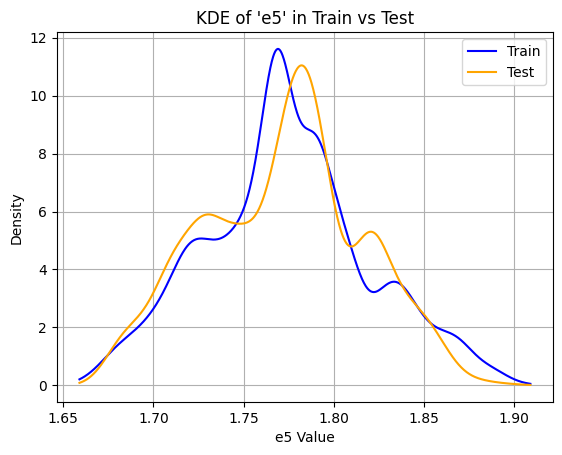

In [34]:
# check distribution of train and test
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

x_train = train_df["e5"].dropna()
x_test = test_df["e5"].dropna()

kde_train = gaussian_kde(x_train)
kde_test = gaussian_kde(x_test)

x_vals = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 1000)
plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
plt.legend()
plt.title("KDE of 'e5' in Train vs Test")
plt.xlabel("e5 Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


In [28]:
scaled_test.shape

(2202, 2)

In [29]:
y_test_final.shape

(864,)

### Model training

In [30]:

# Example multivariate time-series data
# Assume 'data' is a NumPy array of shape (samples, timesteps, features)
# For instance, data.shape = (1000, 30, 5) for 1000 samples, 30 timesteps, and 5 features

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(288, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


# Fit the model
# Assume 'X_train' and 'y_train' are your training data and labels
# model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

In [1]:
model.fit(X, y, epochs=30, batch_size=32)

NameError: name 'model' is not defined

save the model

In [32]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
uuid = '30a50253-2339-469d-a77c-86713d9f5f7f'
fuel= 'e5'
#model.save(f"fuel_price_cnn_model_{timestamp}.h5")
model.save(f"../models_laura/One_station_CNN-LSTM_small_train{timestamp}_{fuel}_{uuid}")

INFO:tensorflow:Assets written to: ../models_laura/One_station_CNN-LSTM_small_train20250612_1023_e5_30a50253-2339-469d-a77c-86713d9f5f7f/assets


INFO:tensorflow:Assets written to: ../models_laura/One_station_CNN-LSTM_small_train20250612_1023_e5_30a50253-2339-469d-a77c-86713d9f5f7f/assets


predictions

In [27]:
#model = load_model('../models_laura/One_station_CNN_20250611_1639_e5_30a50253-2339-469d-a77c-86713d9f5f7f') #first model: something wrong
#model = load_model('../models_laura/One_station_CNN_20250611_1804_e5_30a50253-2339-469d-a77c-86713d9f5f7f') # second model, trained on whole training set
#model = load_model('../models_laura/One_station_CNN_small_train20250611_2025_e5_30a50253-2339-469d-a77c-86713d9f5f7f') #trained with small training set
#model = load_model('../models_laura/One_station_CNN_small_train20250612_0939_e5_30a50253-2339-469d-a77c-86713d9f5f7f') #trained with different training set


model = load_model('../models_laura/One_station_CNN-LSTM_small_train20250612_1023_e5_30a50253-2339-469d-a77c-86713d9f5f7f') #first CNN-LSTM model


# Real forecasting use case
## we predict the last day while putting in the three days before

In [35]:
# Predict only the last day
y_pred_forecast = model.predict(X_forecast)

9/9 [==============================] - 0s 9ms/step


In [36]:
y_pred_forecast.shape

(288, 1)

Reverse the scaling

In [37]:
def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

In [39]:
y_pred = inverse_scale(y_pred_forecast, scaled_train, target_index=0, scaler=scaler)

Reattach the datetime to y_pred

In [40]:
n_predictions = len(y_pred)
start_datetime = pd.to_datetime("2025-05-24 22:00")
time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

# Combine into a DataFrame
y_pred_df = pd.DataFrame({
    "datetime": time_index,
    "Predicted E5": y_pred
})

print(y_pred_df.head())

             datetime  Predicted E5
0 2025-05-24 22:00:00      1.719795
1 2025-05-24 22:05:00      1.760260
2 2025-05-24 22:10:00      1.767061
3 2025-05-24 22:15:00      1.771322
4 2025-05-24 22:20:00      1.765791


In [41]:
y_pred_df.set_index('datetime', inplace=True)

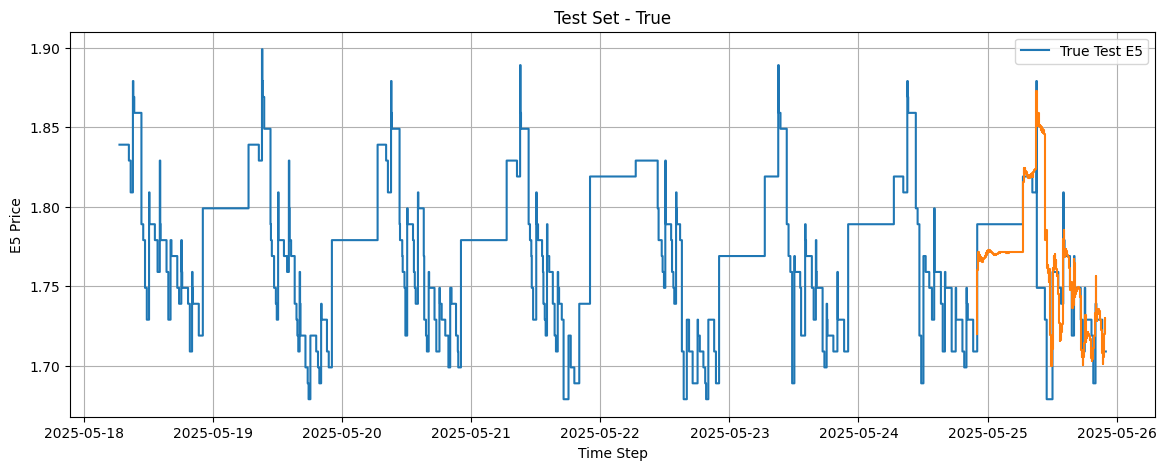

In [42]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'], label='True Test E5', drawstyle='steps-post')
plt.plot(y_pred_df, drawstyle='steps-post')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

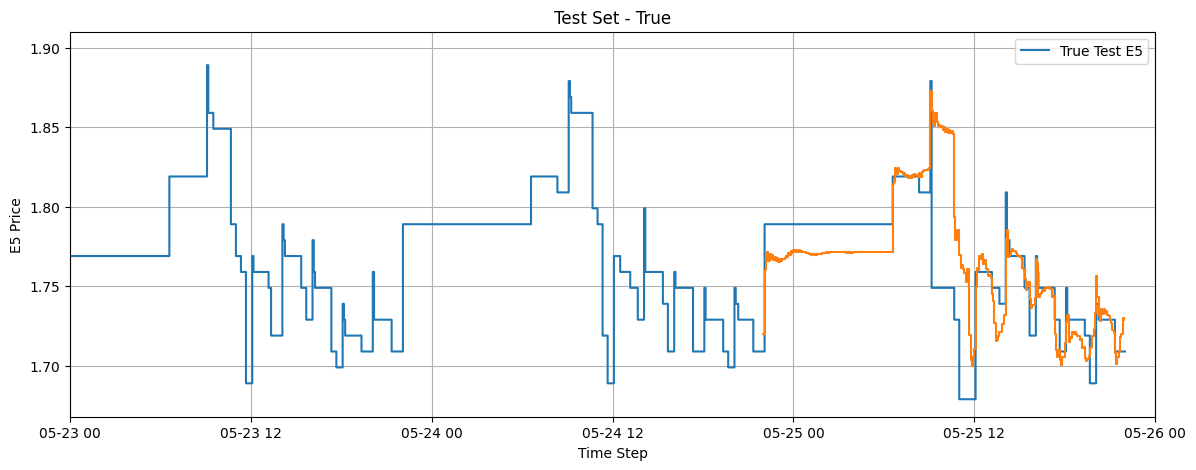

In [43]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'], label='True Test E5', drawstyle='steps-post')
plt.plot(y_pred_df, drawstyle='steps-post')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.xlim((pd.to_datetime('2025-05-23'), pd.to_datetime('2025-05-26')))
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

# Autoregressive prediction

In [44]:
# Then you run auto-regressive prediction:
from tqdm import tqdm

# Define constants
window_size = 288
forecast_days = 1
steps_to_predict = forecast_days * 288
target_index = 0  # Assuming 'e5' is the first column in scaling

# You must cut your test set like this:

test_start = pd.to_datetime("2025-05-23")
test_end = pd.to_datetime("2025-05-25")

input = test_df_[(test_df_.index >= test_start) & 
                       (test_df_.index < test_start + pd.Timedelta(days=7))]

# You use only these first 7 days (7 × 288 = 2016 samples) to form the initial sliding window input:
input_seq = input[["e5", "seasonal_component"]]
input_scaled = scaler.transform(input_seq)


# 2. Initialize sliding window with last 288 time steps (one day)
last_window = input_scaled[-window_size:].copy()

In [45]:
# 3. Autoregressive prediction
predictions_scaled = []
start_index = (test_df_.index.get_loc(test_start))
 # Starting point (after first 7 days)

all_seasonal = test_df_["seasonal_component"].values
seasonal_pattern_length = 288  # One day pattern

for step in tqdm(range(steps_to_predict)):  # Changed _ to step
    input_window = last_window.reshape(1, window_size, -1)  # shape: (1, 288, 2)
    
    # Predict next step
    next_pred_scaled = model.predict(input_window, verbose=0)[0, 0]  # shape: scalar

    # Get seasonal component by wrapping around the daily pattern
    seasonal_idx = (start_index + step) % seasonal_pattern_length
    next_seasonal = all_seasonal[seasonal_idx]
    
    # Create properly formatted input for scaler
    next_seasonal_scaled = scaler.transform([[0, next_seasonal]])[0, 1]
    
    next_input = np.zeros((2,))
    next_input[target_index] = next_pred_scaled
    next_input[1 - target_index] = next_seasonal_scaled

    # Append prediction and slide window
    predictions_scaled.append(next_input[target_index])
    last_window = np.vstack([last_window[1:], next_input])

  0%|          | 0/288 [00:00<?, ?it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
  0%|          | 1/288 [00:00<02:03,  2.32it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
  1%|▏         | 4/288 [00:00<00:31,  8.94it/s]/Users/

In [46]:
# First, inverse scale the predictions
predictions_inv = inverse_scale(np.array(predictions_scaled).reshape(-1, 1), 
                              scaled_train, 
                              target_index=0, 
                              scaler=scaler)

# Create DataFrame with inverse-scaled predictions
n_predictions = len(predictions_inv)
start_datetime = pd.to_datetime("2025-05-22 22:00")
time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

y_pred_df = pd.DataFrame({
    "datetime": time_index,
    "Predicted E5": predictions_inv
})

y_pred_df.set_index('datetime', inplace=True)

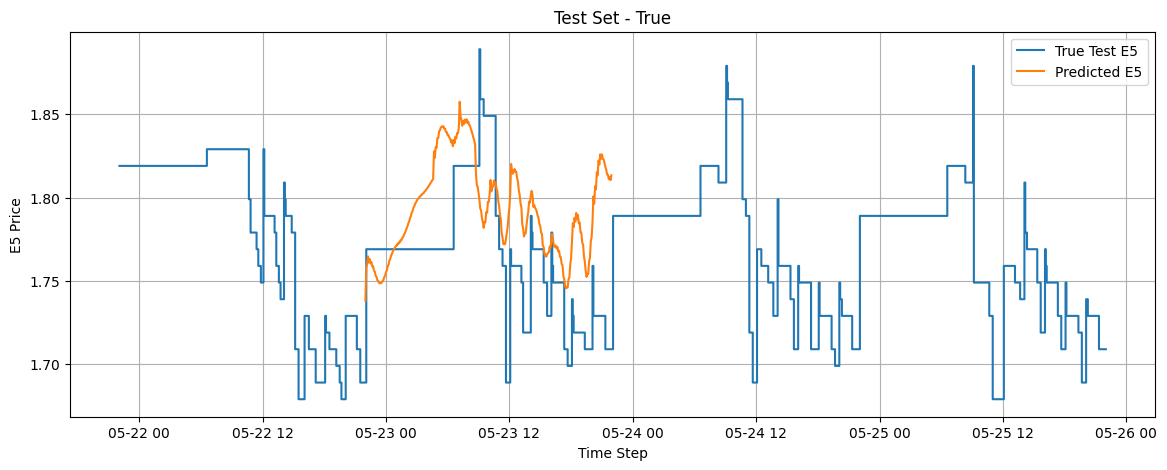

In [47]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'].iloc[-1152:], label='True Test E5', drawstyle='steps-post')
plt.plot(y_pred_df, label='Predicted E5')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()